#### Filter RNAseq and proteomics data on sparsity and variance to prep for MOFA2 analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max.rows', None)


##### RNA-Seq Data Processing #####

In [9]:
# load data
rna_dat = pd.read_csv('../Data/RNA_count_tables/PDAC_tx_TPM_log2_normalized_linkedomics_tumor.csv', index_col=0)
rna_dat.shape

(23213, 140)

In [10]:
# subset to genes with value > 1 in at least 20% of samples
filtered_rna_dat_20 = rna_dat[(rna_dat > 1).sum(axis=1) >= 0.2 * rna_dat.shape[1]]
print(filtered_rna_dat_20.shape)

# subset to genes with value > 1 in at 100% of samples
filtered_rna_dat_100 = rna_dat[(rna_dat > 1).sum(axis=1) >= rna_dat.shape[1]]
print(filtered_rna_dat_100.shape)

(17452, 140)
(11338, 140)


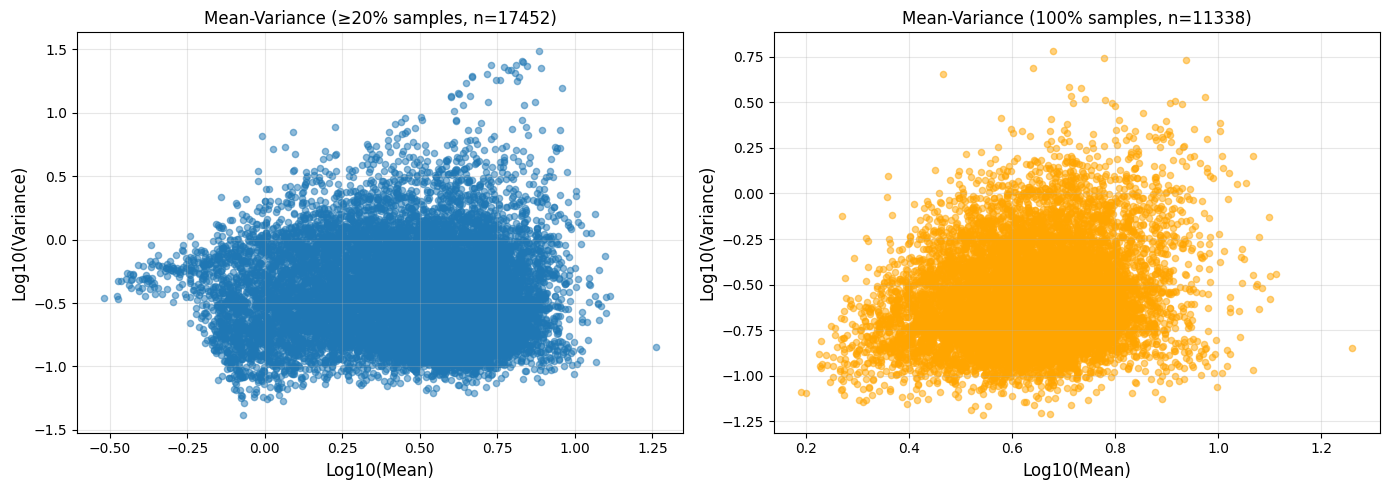

In [11]:
# plot mean-variance for both filters on log scale 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter 1: >= 20% of samples with value > 1
mean_20 = filtered_rna_dat_20.mean(axis=1)
var_20 = filtered_rna_dat_20.var(axis=1)
axes[0].scatter(np.log10(mean_20), np.log10(var_20), alpha=0.5, s=20)
axes[0].set_xlabel('Log10(Mean)', fontsize=12)
axes[0].set_ylabel('Log10(Variance)', fontsize=12)
axes[0].set_title(f'Mean-Variance (≥20% samples, n={filtered_rna_dat_20.shape[0]})', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Filter 2: 100% of samples with value > 1
mean_100 = filtered_rna_dat_100.mean(axis=1)
var_100 = filtered_rna_dat_100.var(axis=1)
axes[1].scatter(np.log10(mean_100), np.log10(var_100), alpha=0.5, s=20, color='orange')
axes[1].set_xlabel('Log10(Mean)', fontsize=12)
axes[1].set_ylabel('Log10(Variance)', fontsize=12)
axes[1].set_title(f'Mean-Variance (100% samples, n={filtered_rna_dat_100.shape[0]})', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [16]:
# subset to 5k most variable genes from the 20% filter
top_5k_var_genes = filtered_rna_dat_20.var(axis=1).nlargest(5000).index
top_5k_var_rna_dat = filtered_rna_dat_20.loc[top_5k_var_genes]
print(top_5k_var_rna_dat.shape)

# scale data (z-score normalization)
mean = top_5k_var_rna_dat.mean(axis=1)
std = top_5k_var_rna_dat.std(axis=1)
# Subtract mean and divide by std along the rows
scaled_rna_dat = top_5k_var_rna_dat.sub(mean, axis=0).div(std, axis=0)

# save the 5k table
scaled_rna_dat.to_csv('../Data/MOFA_input/transcriptome_top5k_hvgs_scaled_tumor.csv')

print(scaled_rna_dat.mean(axis=1).head()) # Should be close to 0
print(scaled_rna_dat.std(axis=1).head())  # Should be close to 1

(5000, 140)
gene_name
PNLIP      5.971414e-16
CPA1       1.839798e-16
CPB1       1.292617e-16
AMY2A     -7.946025e-16
PLA2G1B   -6.058646e-16
dtype: float64
gene_name
PNLIP      1.0
CPA1       1.0
CPB1       1.0
AMY2A      1.0
PLA2G1B    1.0
dtype: float64


##### Proteomics Data Processing #####

In [19]:
# load data
prot_dat = pd.read_csv('../Data/LinkedOmics_data/proteomics_gene_level_MD_abundance_tumor.tsv', sep='\t', index_col=0)
prot_dat.shape

(11662, 140)

In [20]:
# subset to proteins with less than 20% NA values
filtered_prot_dat_20 = prot_data[prot_data.isna().sum(axis=1) <= 0.2 * prot_data.shape[1]]
print(filtered_prot_dat_20.shape)

(7499, 140)


In [21]:
# subset to 5k most variable proteins
top_5k_var_proteins = filtered_prot_dat_20.var(axis=1).nlargest(5000).index
top_5k_var_prot_dat = filtered_prot_dat_20.loc[top_5k_var_proteins]
print(top_5k_var_prot_dat.shape)

# scale the data (z-score normalization)
mean = top_5k_var_prot_dat.mean(axis=1)
std = top_5k_var_prot_dat.std(axis=1)
# Subtract mean and divide by std along the rows
scaled_prot_dat = top_5k_var_prot_dat.sub(mean, axis=0).div(std, axis=0)
scaled_prot_dat.shape
# save the 5k table
scaled_prot_dat.to_csv('../Data/MOFA_input/proteome_top5k_hvgs_scaled_tumor.csv')

print(scaled_prot_dat.mean(axis=1).head()) # Should be close to 0
print(scaled_prot_dat.std(axis=1).head())  # Should be close to 1


(5000, 140)
S100A7   -1.198680e-15
DEFA6     1.785873e-15
S100A2    7.465848e-16
DEFA5     2.099908e-15
CLDN18   -2.607438e-15
dtype: float64
S100A7    1.0
DEFA6     1.0
S100A2    1.0
DEFA5     1.0
CLDN18    1.0
dtype: float64


##### Mutation Data Processing #####

In [42]:
# load Mutation_site_level.cgt
mutation_dat = pd.read_csv("../Data/LinkedOmics_data/Mutation_site_level.cgt", sep="\t")
# drop first column
mutation_dat.drop(columns=mutation_dat.columns[0], inplace=True)
# set first column as index
mutation_dat.set_index(mutation_dat.columns[0], inplace=True)
mutation_dat.head()
mutation_dat.shape

(6149, 140)

In [43]:
# keep mutations that occur in at least 2 samples (columns), ie !=WT occurs at least twice 
mutation_filtered = mutation_dat[(mutation_dat != 'WT').sum(axis=1) >= 2]
print(mutation_filtered.shape)
# if WT then code WT to 0, else to 1
mutation_binary = mutation_filtered.applymap(lambda x: 0 if x == 'WT' else 1)
mutation_binary.head()

(69, 140)


/var/folders/23/slq0qn0d7yv752ftvwgchq1r0000gn/T/ipykernel_30843/4095201874.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mutation_binary = mutation_filtered.applymap(lambda x: 0 if x == 'WT' else 1)


,C3L-00017,C3L-00102,C3L-00189,C3L-00277,C3L-00401,C3L-00589,C3L-00598,C3L-00599,C3L-00622,C3L-00625,C3L-00640,C3L-00819,C3L-00881,C3L-00928,C3L-01031,C3L-01036,C3L-01037,C3L-01051,C3L-01052,C3L-01053,C3L-01054,C3L-01124,C3L-01328,C3L-01453,C3L-01598,C3L-01637,C3L-01662,C3L-01687,C3L-01689,C3L-01703,C3L-01971,C3L-02109,C3L-02112,C3L-02115,C3L-02116,C3L-02118,C3L-02463,C3L-02604,C3L-02606,C3L-02610,C3L-02613,C3L-02701,C3L-02809,C3L-02890,C3L-02897,C3L-02899,C3L-03123,C3L-03356,C3L-03388,C3L-03394,C3L-03395,C3L-03628,C3L-03630,C3L-03632,C3L-03635,C3L-03639,C3L-03743,C3L-04027,C3L-04072,C3L-04080,C3L-04473,C3L-04475,C3L-04479,C3L-04495,C3L-04848,C3L-04853,C3N-00198,C3N-00249,C3N-00302,C3N-00303,C3N-00436,C3N-00511,C3N-00512,C3N-00513,C3N-00514,C3N-00516,C3N-00517,C3N-00518,C3N-00709,C3N-00957,C3N-01011,C3N-01012,C3N-01165,C3N-01166,C3N-01167,C3N-01168,C3N-01375,C3N-01380,C3N-01381,C3N-01382,C3N-01383,C3N-01388,C3N-01502,C3N-01714,C3N-01715,C3N-01716,C3N-01719,C3N-01997,C3N-01998,C3N-02010,C3N-02295,C3N-02573,C3N-02579,C3N-02585,C3N-02589,C3N-02592,C3N-02768,C3N-02940,C3N-02944,C3N-02971,C3N-02998,C3N-03000,C3N-03006,C3N-03007,C3N-03039,C3N-03061,C3N-03069,C3N-03086,C3N-03173,C3N-03190,C3N-03211,C3N-03426,C3N-03428,C3N-03430,C3N-03439,C3N-03440,C3N-03665,C3N-03666,C3N-03670,C3N-03754,C3N-03780,C3N-03839,C3N-03840,C3N-03853,C3N-03884,C3N-04119,C3N-04126,C3N-04282,C3N-04283,C3N-04284
site,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ADAMTSL3.T791M,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
APOBR.G364W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BEND4.N209N,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CCDC180.K781E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CDC27.L278F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(mutation_binary.sum(axis=1).max()) # max number of mutations in a gene
print(mutation_binary.sum(axis=0).max()) # max number of mutations in a sample
# save the binary mutation table
mutation_binary.to_csv('../Data/MOFA_input/mutation_binary_min_1_mut_in_2caseIDs_tumor.csv')

61
6
